In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

import pickle
from IPython.display import clear_output

In [2]:
#select model to train. options = ['linreg','rf','xgboost']
model = 'linreg'

## Data Preprocessing

In [3]:
#import data
df = pd.read_csv('data.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,...,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD
0,2000-01,1610612748,20000711,2001-02-13,32.566627,75.379888,0.431046,5.985385,16.841769,0.359586,...,0.499858,91.842791,90.241110,75.200835,91.170350,0.459733,1208.524359,0.3,3.0,2.0
1,2000-01,1610612757,20000721,2001-02-13,35.962227,77.211776,0.466868,4.220501,12.052706,0.353236,...,0.532081,94.340068,93.002160,77.501961,93.457272,0.539347,1385.270634,1.0,3.0,21.0
2,2000-01,1610612765,20000726,2001-02-14,35.465604,82.914284,0.430438,4.617979,12.315828,0.376773,...,0.500503,94.213314,93.280620,77.734403,93.687134,0.437982,1162.723408,0.3,1.0,19.0
3,2000-01,1610612761,20000729,2001-02-15,37.073126,84.315275,0.441021,5.205290,13.681417,0.375542,...,0.524140,89.148013,88.330002,73.608042,90.025072,0.539860,1397.788078,0.8,2.0,-7.0
4,2000-01,1610612760,20000734,2001-02-15,36.650991,80.249629,0.457681,5.456750,13.887473,0.404631,...,0.517887,95.509993,94.143420,78.452760,94.815955,0.483302,1242.003286,0.7,3.0,-20.0


In [4]:
df['SEASON'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18',
       '2018-19', '2019-20', '2020-21', '2021-22'], dtype=object)

In [5]:
#create training and test sets
test_seasons = ['2017-18',
                '2018-19',
                '2019-20',
                '2020-21',
                '2021-22']

train_df = df[~df['SEASON'].isin(test_seasons)].copy()
test_df = df[df['SEASON'].isin(test_seasons)].copy()

In [6]:
train_df.columns

Index(['SEASON', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE', 'FGM_HOME',
       'FGA_HOME', 'FG_PCT_HOME', 'FG3M_HOME', 'FG3A_HOME', 'FG3_PCT_HOME',
       'FTM_HOME', 'FTA_HOME', 'FT_PCT_HOME', 'OREB_HOME', 'DREB_HOME',
       'REB_HOME', 'AST_HOME', 'STL_HOME', 'BLK_HOME', 'TOV_HOME', 'PF_HOME',
       'PTS_HOME', 'PLUS_MINUS_HOME', 'TEAM_CITY_HOME', 'E_OFF_RATING_HOME',
       'OFF_RATING_HOME', 'E_DEF_RATING_HOME', 'DEF_RATING_HOME',
       'E_NET_RATING_HOME', 'NET_RATING_HOME', 'AST_PCT_HOME', 'AST_TOV_HOME',
       'AST_RATIO_HOME', 'OREB_PCT_HOME', 'DREB_PCT_HOME', 'REB_PCT_HOME',
       'E_TM_TOV_PCT_HOME', 'TM_TOV_PCT_HOME', 'EFG_PCT_HOME', 'TS_PCT_HOME',
       'E_PACE_HOME', 'PACE_HOME', 'PACE_PER40_HOME', 'POSS_HOME', 'PIE_HOME',
       'ELO_HOME', 'RECENT_WIN_PCT_HOME', 'REST_DAYS_HOME', 'TEAM_ID_AWAY',
       'FGM_AWAY', 'FGA_AWAY', 'FG_PCT_AWAY', 'FG3M_AWAY', 'FG3A_AWAY',
       'FG3_PCT_AWAY', 'FTM_AWAY', 'FTA_AWAY', 'FT_PCT_AWAY', 'OREB_AWAY',
       'DREB_AWAY', 'REB_AWA

In [7]:
#drop unnecessary columns
train_df.drop(columns=['SEASON',
                       'TEAM_ID_HOME',
                       'GAME_ID',
                       'GAME_DATE',
                       'TEAM_ID_AWAY',
                       'TEAM_CITY_HOME',
                       'TEAM_CITY_AWAY'], inplace=True)
test_df.drop(columns=['SEASON',
                       'GAME_ID',
                       'TEAM_ID_AWAY'], inplace=True)

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [8]:
test_df.head()

,TEAM_ID_HOME,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD
0,1610612739,2017-10-17,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,...,0.566162,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0
1,1610612744,2017-10-17,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,...,0.568099,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0
2,1610612765,2017-10-18,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,...,0.552015,96.343427,94.650879,78.875791,95.251881,0.490943,1473.114932,0.4,3.0,12.0
3,1610612754,2017-10-18,39.926003,85.017516,0.470463,9.567652,24.508514,0.387135,16.889065,21.116228,...,0.550202,103.275096,101.707620,84.756484,101.841005,0.478798,1357.069190,0.5,3.0,9.0
4,1610612753,2017-10-18,38.876910,88.284417,0.440425,8.685238,26.505495,0.326234,17.322239,21.988664,...,0.560482,97.906908,96.011883,80.009967,96.494008,0.517589,1557.174778,0.6,3.0,7.0


In [9]:
#seperate target variable

y_train = train_df['GAME_SPREAD'].copy()
X_train = train_df.drop(columns=['GAME_SPREAD']).copy()

In [10]:
#standardize data

sclr = StandardScaler()
X_train[list(X_train.columns)] = sclr.fit_transform(X_train)

Text(0, 0.5, 'cumulative explained variance')

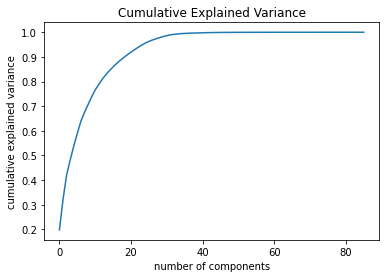

In [11]:
#PCA to minimize multicollinearity
pca = PCA().fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [12]:
#apply dimensionality reduction to data, keeping n components
n_components = 30
pca=PCA(n_components=n_components)

X_train = pd.DataFrame(pca.fit_transform(X_train))

In [13]:
#import betting spreads data
book_spreads_df = pd.read_csv('spreads_df.csv')
book_spreads_df.drop(columns=['Unnamed: 0'], inplace=True)
book_spreads_df.head()

,GM_DATE,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2021-10-19,Milwaukee,+1½,-110,+2,-113,+2,-113,+2½,-135,-1½,-110,-2,-108,-2,-108,-2½,-105
1,2021-10-19,L.A. Lakers,+3,-110,+3,-112,+3,-112,+4,-135,-3,-110,-3,-109,-3,-109,-4,-105
2,2021-10-20,Charlotte,-1,+100,+½,-110,+1½,-110,-1½,-110,+1,-120,-½,-110,-1½,-112,+1½,-110
3,2021-10-20,Detroit,-5,-110,-5,-112,-5,-112,-5,-110,+5,-110,+5,-110,+5,-110,+5,-110
4,2021-10-20,Toronto,+2½,-110,+2½,-109,+3,-109,+4½,-160,-2½,-110,-2½,-112,-3,-112,-4½,+115


In [14]:
#create lookup for team id and team city
team_id_city_lookup = {}
for i, row in test_df.iterrows():
    team_id = row['TEAM_ID_HOME']
    team_city = row['TEAM_CITY_HOME']
    if team_id not in team_id_city_lookup:
        team_id_city_lookup[team_id] = [team_city]
    elif team_city not in team_id_city_lookup[team_id]:
        team_id_city_lookup[team_id].append(team_city)
team_id_city_lookup

{1610612739: ['Cleveland'],
 1610612744: ['Golden State'],
 1610612765: ['Detroit'],
 1610612754: ['Indiana'],
 1610612753: ['Orlando'],
 1610612764: ['Washington'],
 1610612738: ['Boston'],
 1610612763: ['Memphis'],
 1610612742: ['Dallas'],
 1610612762: ['Utah'],
 1610612759: ['San Antonio'],
 1610612756: ['Phoenix'],
 1610612758: ['Sacramento'],
 1610612761: ['Toronto'],
 1610612760: ['Oklahoma City'],
 1610612747: ['Los Angeles'],
 1610612766: ['Charlotte'],
 1610612755: ['Philadelphia'],
 1610612749: ['Milwaukee'],
 1610612751: ['Brooklyn'],
 1610612750: ['Minnesota'],
 1610612740: ['New Orleans'],
 1610612748: ['Miami'],
 1610612752: ['New York'],
 1610612741: ['Chicago'],
 1610612745: ['Houston'],
 1610612743: ['Denver'],
 1610612746: ['LA'],
 1610612757: ['Portland'],
 1610612737: ['Atlanta']}

In [15]:
#clean up lookup table to align team ids with team city names from sportsbooks
team_id_city_lookup[1610612747] = ['L.A. Lakers']
team_id_city_lookup[1610612746] = ['L.A. Clippers']
team_id_city_lookup[1610612760] = ['Oklahoma City']
team_id_city_lookup[1610612751] = ['Brooklyn']
team_id_city_lookup[1610612763] = ['Memphis']
team_id_city_lookup[1610612740] = ['New Orleans']

team_city_id_lookup = {}

for key, val in team_id_city_lookup.items():
    team_city_id_lookup[val[0]] = key

team_city_id_lookup

{'Cleveland': 1610612739,
 'Golden State': 1610612744,
 'Detroit': 1610612765,
 'Indiana': 1610612754,
 'Orlando': 1610612753,
 'Washington': 1610612764,
 'Boston': 1610612738,
 'Memphis': 1610612763,
 'Dallas': 1610612742,
 'Utah': 1610612762,
 'San Antonio': 1610612759,
 'Phoenix': 1610612756,
 'Sacramento': 1610612758,
 'Toronto': 1610612761,
 'Oklahoma City': 1610612760,
 'L.A. Lakers': 1610612747,
 'Charlotte': 1610612766,
 'Philadelphia': 1610612755,
 'Milwaukee': 1610612749,
 'Brooklyn': 1610612751,
 'Minnesota': 1610612750,
 'New Orleans': 1610612740,
 'Miami': 1610612748,
 'New York': 1610612752,
 'Chicago': 1610612741,
 'Houston': 1610612745,
 'Denver': 1610612743,
 'L.A. Clippers': 1610612746,
 'Portland': 1610612757,
 'Atlanta': 1610612737}

In [16]:
#add team ids to sportsbook df
book_spreads_df['TEAM_ID_HOME'] = book_spreads_df.apply(lambda row: team_city_id_lookup[row['HOME_TEAM']], axis=1)

#merge test_df and sportsbook data
book_spreads_df.rename(columns={'GM_DATE':'GAME_DATE'}, inplace=True)
test_df['GAME_DATE'] = pd.to_datetime(test_df['GAME_DATE'])
book_spreads_df['GAME_DATE'] = pd.to_datetime(book_spreads_df['GAME_DATE'])
test_df = test_df.merge(book_spreads_df, on=['GAME_DATE', 'TEAM_ID_HOME'], how='inner')
test_df.head()

,TEAM_ID_HOME,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,1610612739,2017-10-17,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,...,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-
1,1610612744,2017-10-17,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,...,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-
2,1610612765,2017-10-18,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,...,NaN,-,-3,-110,+4½,-250,NaN,-,NaN,-
3,1610612754,2017-10-18,39.926003,85.017516,0.470463,9.567652,24.508514,0.387135,16.889065,21.116228,...,NaN,-,-3,-110,+5½,-305,NaN,-,NaN,-
4,1610612753,2017-10-18,38.876910,88.284417,0.440425,8.685238,26.505495,0.326234,17.322239,21.988664,...,NaN,-,+3½,-110,+9½,-250,NaN,-,NaN,-


In [17]:
#convert fractional betting spread strings into floats

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [18]:
#process testing data

#isolate target variable and drop unnecessary non-feature columns
y_test = test_df['GAME_SPREAD'].copy()
X_test = test_df.drop(columns=['GAME_SPREAD', 
                               'TEAM_CITY_HOME', 
                               'TEAM_CITY_AWAY', 
                               'TEAM_ID_HOME', 
                               'GAME_DATE',
                               'HOME_TEAM',
                               'SPREAD_1_AWAY',
                               'ODDS_1_AWAY',
                               'SPREAD_2_AWAY',
                               'ODDS_2_AWAY',
                               'SPREAD_3_AWAY',
                               'ODDS_3_AWAY',
                               'SPREAD_4_AWAY',
                               'ODDS_4_AWAY',
                               'SPREAD_1_HOME',
                               'ODDS_1_HOME',
                               'SPREAD_2_HOME',
                               'ODDS_2_HOME',
                               'SPREAD_3_HOME',
                               'ODDS_3_HOME',
                               'SPREAD_4_HOME',
                               'ODDS_4_HOME']).copy()

#standardize
X_test[list(X_test.columns)] = sclr.transform(X_test)

#pca
X_test = pd.DataFrame(pca.transform(X_test))

In [19]:
#isolate book spreads
book_spreads = test_df[['SPREAD_1_AWAY',
                        'ODDS_1_AWAY',
                        'SPREAD_2_AWAY',
                        'ODDS_2_AWAY',
                        'SPREAD_3_AWAY',
                        'ODDS_3_AWAY',
                        'SPREAD_4_AWAY',
                        'ODDS_4_AWAY']].copy()

#convert fraction spreads to floats
book_spreads['SPREAD_1_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_1_AWAY']), axis=1)
book_spreads['SPREAD_2_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_2_AWAY']), axis=1)
book_spreads['SPREAD_3_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_3_AWAY']), axis=1)
book_spreads['SPREAD_4_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_4_AWAY']), axis=1)

book_spreads.head()

,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY
0,4.5,-110,12.5,-345,NaN,-,NaN,-
1,9.5,-115,2.5,+270,NaN,-,NaN,-
2,3.0,-110,-5.5,+240,NaN,-,NaN,-
3,3.0,-110,-5.5,+240,NaN,-,NaN,-
4,-3.5,-110,-11.5,+260,NaN,-,NaN,-


## Model Implementation

In [20]:
#implement linear regression
#if model == 'linreg':
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print('Train COD: ', lin_reg.score(X_train, y_train))

Train COD:  0.1702879002276405


In [21]:
#implement baseline random forest
#if model == 'rf':
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print('Train COD: ', rf.score(X_train, y_train))

Train COD:  0.880638047226829


In [14]:
#tune random forest
if model == 'rf':

    n_estimators = [int(x) for x in np.linspace(start=100, stop=250, num=10)]
    max_features = ['sqrt', 'log2', None]
    #max_depth = [int(x) for x in np.linspace(10,110, num=11)]
    max_depth = [int(x) for x in np.linspace(3, 30, num=10)]
    min_samples_leaf = [1, 2, 4, 6]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=3, verbose=10)
    rf_random.fit(X_train, y_train)
    clear_output()


In [15]:
#save tuned random forest
if model == 'rf':
    rf_tuned = rf_random.best_estimator_
    print('Tuned Train COD: ', rf_tuned.score(X_train, y_train))
    print('Best Params: ', rf_random.best_params_)
    pickle.dump(rf_tuned, open('rf.pkl', 'wb'))

Tuned Train COD:  0.31935644990624545
Best Params:  {'n_estimators': 133, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': 9, 'bootstrap': True}


In [22]:
#implement xgboost
if model == 'xgboost':

    xgb = XGBRegressor()

    xgb.fit(X_train, y_train)
    print('Train COD: ', xgb.score(X_train, y_train))

Train COD:  0.5658147021129669


In [23]:
#XGBoost tuning using hyperopt

#define hyperparameter space
if model == 'xgboost':
    hp_space = {'max_depth': hp.quniform('max_depth', 3, 10, 1),
                'eta': hp.uniform('eta', 0.01, 0.5),
                'gamma': hp.uniform('gamma', 0, 20),
                'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                'n_estimators': 100,
                'seed': 3
    }

    #define objective function
    def objective(space):
        clf=XGBRegressor(n_estimators=space['n_estimators'],
                         max_depth = int(space['max_depth']),
                         eta=space['eta'],
                         gamma=space['gamma'],
                         min_child_weight=space['min_child_weight'],
                         seed=space['seed']
                         )

        evaluation = [(X_train, y_train),(X_test, y_test)]

        clf.fit(X_train, y_train,
               eval_set=evaluation)

        cod = clf.score(X_test, y_test)

        #since we will minimize this objective function, we will return the negative COD to find the best hyperparameters
        return {'loss': -cod, 'status': STATUS_OK}

In [24]:
#search hyperparameter space for values that minimize the objective function
if model == 'xgboost':
    trials = Trials()

    best_params = fmin(fn=objective,
                      space=hp_space,
                      algo = tpe.suggest,
                      max_evals = 100,
                      trials=trials)

    clear_output()
    print(best_params)
    xgb_tuned = XGBRegressor(eta=best_params['eta'],
                            gamma=best_params['gamma'],
                            max_depth=int(best_params['max_depth']),
                            min_child_weight=best_params['min_child_weight'])
    
    xgb_tuned.fit(X_train, y_train)
    
    pickle.dump(xgb_tuned, open('xgb.pkl', 'wb'))

[0]	validation_0-rmse:12.38128	validation_1-rmse:14.17647
[1]	validation_0-rmse:11.71922	validation_1-rmse:13.97377
[2]	validation_0-rmse:11.24300	validation_1-rmse:13.86732
[3]	validation_0-rmse:10.86801	validation_1-rmse:13.82862
[4]	validation_0-rmse:10.57219	validation_1-rmse:13.79251
[5]	validation_0-rmse:10.38963	validation_1-rmse:13.81967
[6]	validation_0-rmse:10.21003	validation_1-rmse:13.82365
[7]	validation_0-rmse:10.01612	validation_1-rmse:13.86091
[8]	validation_0-rmse:9.85499	validation_1-rmse:13.91980
[9]	validation_0-rmse:9.68809	validation_1-rmse:14.00723
[10]	validation_0-rmse:9.58820	validation_1-rmse:14.04550
[11]	validation_0-rmse:9.47963	validation_1-rmse:14.05450
[12]	validation_0-rmse:9.38631	validation_1-rmse:14.09290
[13]	validation_0-rmse:9.27440	validation_1-rmse:14.14011
[14]	validation_0-rmse:9.14642	validation_1-rmse:14.16959
[15]	validation_0-rmse:9.05055	validation_1-rmse:14.18227
[16]	validation_0-rmse:8.95566	validation_1-rmse:14.19160
[17]	validation_

KeyboardInterrupt: 

## Model Evaluation

In [45]:
#define evaluation funtion
def evaluate_model(trained_model, confidence_threshold=0, outlier_threshold=100):
    
    #get predicted spreads
    preds = trained_model.predict(X_test)
    print('Train COD: ', trained_model.score(X_train, y_train))
    print('Test COD: ', trained_model.score(X_test, y_test))
    
    count_correct = 0
    count_bets = 0
    
    incorrect_pred = []
    incorrect_target = []
    correct_pred = []
    correct_target = []
    
    for i, pred_spread in enumerate(preds):
        
        book_1_spread = book_spreads.iloc[i,0]
        actual_spread = y_test.iloc[i]
        
        if (abs(pred_spread - book_1_spread) > outlier_threshold) or (abs(pred_spread - book_1_spread) < confidence_threshold):
            continue
            
        if (actual_spread < book_1_spread and pred_spread < book_1_spread) or (actual_spread > book_1_spread and pred_spread > book_1_spread):
            count_correct += 1
            correct_pred.append(pred_spread)
            correct_target.append(actual_spread)
        else:
            incorrect_pred.append(pred_spread)
            incorrect_target.append(actual_spread)
            
        count_bets += 1
            
    print('Win Percentage: ', count_correct/count_bets)
    print('Percent of possible bets placed: ', count_bets/len(preds))
    return incorrect_pred, incorrect_target, correct_pred, correct_target

In [53]:
#if model == 'linreg':
incorrect_pred, incorrect_target, correct_pred, correct_target = evaluate_model(lin_reg)

Train COD:  0.1702879002276405
Test COD:  0.1457078992013492
Win Percentage:  0.46479550922213314
Percent of possible bets placed:  1.0


(array([ 14., 100., 304., 598., 883., 759., 475., 152.,  49.,   3.]),
 array([-14.56588456, -10.93933665,  -7.31278874,  -3.68624083,
         -0.05969292,   3.56685499,   7.1934029 ,  10.81995081,
         14.44649872,  18.07304663,  21.69959454]),
 <BarContainer object of 10 artists>)

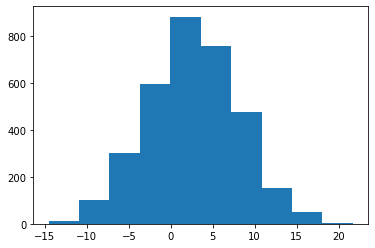

In [54]:
plt.hist(incorrect_pred)

(array([  8.,  22., 147., 454., 938., 654., 733., 286.,  74.,  21.]),
 array([-57., -46., -35., -24., -13.,  -2.,   9.,  20.,  31.,  42.,  53.]),
 <BarContainer object of 10 artists>)

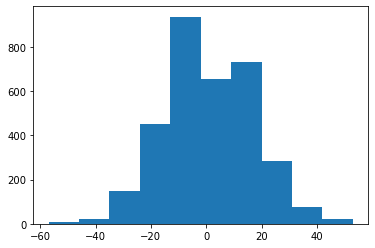

In [55]:
plt.hist(incorrect_target)

(array([  6.,  25., 138., 386., 669., 793., 554., 240.,  77.,  10.]),
 array([-16.38519976, -12.69827488,  -9.01135   ,  -5.32442512,
         -1.63750023,   2.04942465,   5.73634953,   9.42327441,
         13.11019929,  16.79712417,  20.48404905]),
 <BarContainer object of 10 artists>)

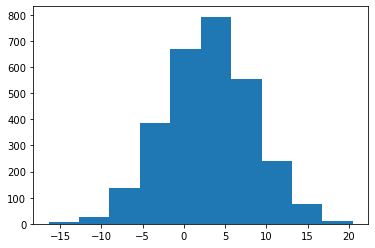

In [56]:
plt.hist(correct_pred)

(array([1.000e+00, 1.700e+01, 1.090e+02, 5.710e+02, 1.284e+03, 7.010e+02,
        1.780e+02, 3.300e+01, 2.000e+00, 2.000e+00]),
 array([-56. , -43.1, -30.2, -17.3,  -4.4,   8.5,  21.4,  34.3,  47.2,
         60.1,  73. ]),
 <BarContainer object of 10 artists>)

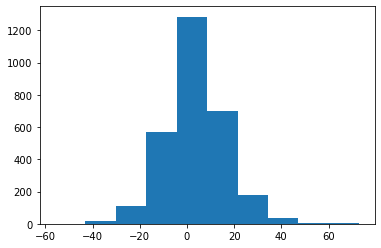

In [57]:
plt.hist(correct_target)

In [35]:
#if model == 'rf':
evaluate_model(rf)


Train COD:  0.880638047226829
Test COD:  0.11567864976077791
Win Percentage:  0.4644747393744988
Percent of possible bets placed:  1.0


In [102]:
#if model == 'rf':
rf_tuned = pickle.load(open('rf.pkl', 'rb'))
evaluate_model(rf_tuned)

Train COD:  0.31935653427061084
Test COD:  0.13226865538808896
Win Percentage:  0.4662626924336718
Percent of possible bets placed:  0.9793103448275862


In [103]:
if model == 'xgboost':
    evaluate_model(xgb)

NameError: name 'xgb' is not defined

In [104]:
#if model == 'xgboost':
xgb_tuned = pickle.load(open('xgb.pkl', 'rb'))
evaluate_model(xgb_tuned)

Train COD:  0.19931846831188504
Test COD:  0.13321762926716763
Win Percentage:  0.46510100180653635
Percent of possible bets placed:  0.9765838011226945
